In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


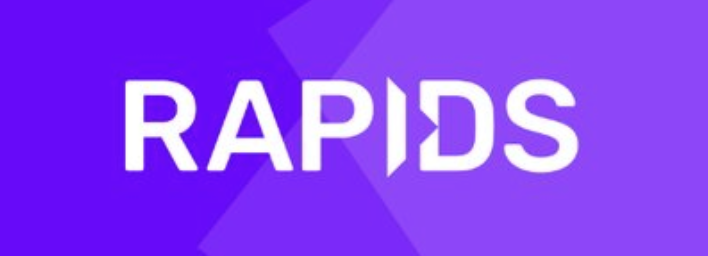

* [Fancy website](https://rapids.ai/#quick-start)
* [Github](https://github.com/rapidsai/)
* [Docs](https://docs.rapids.ai/api/cudf/stable/)

____

WHAT IS **RAPIDS**

**RAPIDS** provides unmatched speed with familiar APIs that match the most popular PyData libraries. Built on state-of-the-art foundations like NVIDIA CUDA and Apache Arrow, it unlocks the speed of GPUs with code you already know.

* Dataframe processing with cuDF (similar API to pandas)
* Machine learning with cuML (similar API to scikit-learn)
* Graph processing with cuGraph (similar API to networkX)
* Spatial analytics with cuSpatial (similar API to geoPandas)
* Image processing with cuCIM (similar API to scikit-image)
* Seamless cross-filtered dashboards with cuxfilter
* Low level compute primitives with RAFT
* Apache Spark acceleration with Spark RAPIDS

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import random
import numpy as np

In [ ]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.32
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

In [ ]:
!nvidia-smi

Fri Aug 16 10:25:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Pandas

In [ ]:
%%time
df = pd.read_csv("drive/MyDrive/dummy_dataset.csv").sample(1_000_000, random_state=77)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
%%time
cols_for_groupping = ["name", "hair_color", "accession_month", "credit_card_expire", "currency", "city"]
cols_for_aggregation_num = ["balance", "debt", "building_number", "credit_card_number", "credit_card_security_code", "coordinate"]
cols_for_aggregation_cat = ["country", "street_name", "credit_card_expire"]
for col in tqdm(cols_for_groupping):
    aggs = {num: ["mean", "median", "std"] for num in cols_for_aggregation_num}
    #aggs.update({cat: pd.Series.mode for cat in cols_for_aggregation_cat})
    temp = df.groupby(by=col).agg(aggs)
    del temp

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 2.39 s, sys: 10.5 ms, total: 2.4 s
Wall time: 2.41 s


In [ ]:
arr = []
for i in range(3):
    aggs = {num: ["mean", "median", "std"] for num in cols_for_aggregation_num}
    arr.append(df.groupby(by=cols_for_groupping[i], as_index=False)
               .agg(aggs).droplevel(level=0, axis=1)
               .rename(columns=lambda x: x + f"_{i}_{random.random()}" if x != "" else cols_for_groupping[i]))

In [ ]:
%%time
for i in tqdm(range(3)):
    df = df.merge(arr[i], on=cols_for_groupping[i], how="left")

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 2.42 s, sys: 838 ms, total: 3.26 s
Wall time: 3.32 s


In [ ]:
del arr; del df

In [ ]:
df = pd.read_csv("drive/MyDrive/dummy_dataset.csv").sample(1_000_000, random_state=77)

In [ ]:
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include="object").columns

In [ ]:
%%time
df[[col + "_sqrt" for col in num_cols]] = df[num_cols].pow(0.5)
df[[col + "_add" for col in num_cols]] = df[num_cols] + 5
df.assign(**{col + "_tail": df[col].str[-3:] for col in cat_cols})

CPU times: user 8.03 s, sys: 112 ms, total: 8.15 s
Wall time: 8.14 s


,id,name,birth_date,hair_color,is_MU_fan,iq,accession_month,balance,debt,country,...,city_tail,street_name_tail,license_plate_tail,vin_tail,swift_tail,company_name_tail,company_suffix_tail,job_name_tail,credit_card_expire_tail,currency_tail
3887690,962,Danielle,2007-06-11,Sienna,False,466,5,2.374911e+08,2.933001e+09,Jersey,...,ort,nch,KRQ,9RJ,B5Q,don,ons,ist,/34,JEP
84319,4952,Jeffrey,2020-01-01,MediumVioletRed,True,971,12,3.399260e+08,7.442588e+09,Monaco,...,ugh,dow,RBX,V1Z,B85,ate,oup,ger,/25,DKK
1194275,316,Bruce,2001-11-04,LightGoldenRodYellow,False,326,8,3.368817e+08,8.865531e+09,Mongolia,...,ort,ove,U56,5CK,BMQ,Ltd,LLC,yor,/26,BAM
1153913,7474,Kyle,2005-11-13,PapayaWhip,True,592,7,8.786440e+07,2.925486e+09,Bosnia and Herzegovina,...,ori,eld,397,ZH5,B0C,oup,oup,ial,/26,BYR
13267,8317,Kayla,2014-05-10,Tomato,True,87,10,3.520182e+08,9.450922e+09,Barbados,...,tin,rgs,060,EM8,BT3,una,Inc,ist,/28,VND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138277,946,Brandy,2007-10-13,PapayaWhip,True,416,9,9.128475e+08,4.211934e+09,Puerto Rico,...,ire,nds,49O,H9J,B0F,non,LLC,IT,/29,COP
1421804,3027,Stephen,2012-03-27,CadetBlue,False,448,4,2.963725e+08,9.953720e+09,Burkina Faso,...,ury,dge,5VO,TJ6,BGJ,aig,LLC,ter,/26,YER
4998499,8317,Jennifer,2020-09-26,Silver,True,974,8,8.265195e+08,4.028849e+09,Afghanistan,...,ugh,eys,215,LPV,BIL,ite,LLC,cer,/29,TMT
2355658,4587,Tyler,2020-06-29,Plum,True,530,10,4.601135e+08,6.819438e+09,British Indian Ocean Territory (Chagos Archipe...,...,erg,way,UL2,PJ3,BWY,ble,LLC,tus,/34,MYR


In [ ]:
del df

## CuDF

In [ ]:
import cudf
%load_ext cudf.pandas

In [ ]:
%%time
import pandas as pd
df = pd.read_csv("drive/MyDrive/dummy_dataset.csv").sample(1_000_000, random_state=77)
df["coordinate"] = df["coordinate"].astype(float)

CPU times: user 1.3 s, sys: 906 ms, total: 2.2 s
Wall time: 5.05 s


In [ ]:
%%time
cols_for_groupping = ["name", "hair_color", "accession_month", "credit_card_expire", "currency", "city"]
cols_for_aggregation_num = ["balance", "debt", "building_number", "credit_card_number", "credit_card_security_code", "coordinate"]
cols_for_aggregation_cat = ["country", "street_name", "credit_card_expire"]
for col in tqdm(cols_for_groupping):
    aggs = {num: ["mean", "median", "std"] for num in cols_for_aggregation_num}
    #aggs.update({cat: pd.Series.mode for cat in cols_for_aggregation_cat})
    temp = df.groupby(by=col).agg(aggs)
    del temp

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 649 ms, sys: 172 ms, total: 820 ms
Wall time: 2.07 s


In [ ]:
arr = []
for i in range(3):
    aggs = {num: ["mean", "median", "std"] for num in cols_for_aggregation_num}
    arr.append(df.groupby(by=cols_for_groupping[i], as_index=False)
               .agg(aggs).droplevel(level=0, axis=1)
               .rename(columns=lambda x: x + f"_{i}_{random.random()}" if x != "" else cols_for_groupping[i]))

In [ ]:
%%time
for i in tqdm(range(3)):
    df = df.merge(arr[i], on=cols_for_groupping[i], how="left")

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 186 ms, sys: 59.1 ms, total: 245 ms
Wall time: 308 ms


In [ ]:
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include="object").columns

In [ ]:
%%time
df[[col + "_sqrt" for col in num_cols]] = df[num_cols].pow(0.5)
df[[col + "_add" for col in num_cols]] = df[num_cols] + 5
df.assign(**{col + "_tail": df[col].str[-3:] for col in cat_cols})

CPU times: user 15.7 s, sys: 7.7 s, total: 23.4 s
Wall time: 22.8 s


KeyboardInterrupt: 

What?)

![](https://media1.tenor.com/m/6aPIEyt7K3IAAAAC/why-monkey.gif)

## Bonus &#x1F381; - CuML
[GitHub](https://github.com/rapidsai/cuml/tree/branch-24.10)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cuml-cu12==24.8.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [ ]:
from cuml.ensemble import RandomForestRegressor as curfr
from cuml.metrics import accuracy_score

from sklearn.ensemble import RandomForestRegressor as skrfr

In [ ]:
import cudf
df = cudf.read_csv("drive/MyDrive/dummy_dataset.csv").sample(1_000_000, random_state=77)

In [ ]:
num_cols = df.select_dtypes(include='number').columns

In [ ]:
x = df[num_cols].drop(columns="balance")
y = df["balance"]

In [ ]:
%%time
curfr().fit(x, y)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


CPU times: user 7.12 s, sys: 4.79 s, total: 11.9 s
Wall time: 7.09 s


RandomForestRegressor()

In [ ]:
x_nu = x.sample(100_000).to_numpy()
y_nu = y.sample(100_000).to_numpy()

In [ ]:
%%time
skrfr().fit(x_nu, y_nu)

CPU times: user 3min 8s, sys: 2.47 s, total: 3min 11s
Wall time: 3min 7s


RandomForestRegressor()